<a href="https://colab.research.google.com/github/ubern-mia/bme-labs/blob/main/DLexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Example

This example gives a brief example on how to do a simple classification from MRI data. It takes images from the IXI dataset, where we have information about the sex of the subject alongside an MRI. We will try to directly infer the sex of a given patient from MRI. It is heavily inspired by this MONAI example: https://colab.research.google.com/github/Project-MONAI/MONAIBootcamp2021/blob/master/day1/3.%20End-To-End%20Workflow%20with%20MONAI.ipynb 
MONAI is a framework built on PyTorch specifically for deep learning with medical imaging data.

To make the data easier to handle, the data is resized to a volume of 32x32x32 voxels. Preprocessing further included cropping to the foreground and z-score normalization.

## Enabling GPU Support

To use GPU resources through Colab, change the runtime to GPU:

    From the "Runtime" menu select "Change Runtime Type"
    Choose "GPU" from the drop-down menu
    Click "SAVE"

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running

!nvidia-smi

in a cell will verify this has worked and show you what kind of hardware you have access to.


First, we download the data and install some required packages. We will use MONAI and PyTorch.


In [1]:
!wget https://www.dropbox.com/s/c15o4fi5qjakeym/ixi_t1_fgcrop_32.h5

--2022-03-10 16:05:37--  https://www.dropbox.com/s/c15o4fi5qjakeym/ixi_t1_fgcrop_32.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/c15o4fi5qjakeym/ixi_t1_fgcrop_32.h5 [following]
--2022-03-10 16:05:37--  https://www.dropbox.com/s/raw/c15o4fi5qjakeym/ixi_t1_fgcrop_32.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea51d7de7c7e5078ecfed1d11d.dl.dropboxusercontent.com/cd/0/inline/BhMQw9c-epexnyLXFzUW2PXlDwwG5GOsXmcd_6xe_ZIQ-jCBWrwtKFZ4S9702Vgv1uy6Nwb7CPs2RvWXbHNfDSi1NR_eeXJUJcBqqlHAzjVKJEfRnqB_YkoTmN-tpwHGHVmLTHYQ1zWBU4z_PFuopFippdEiVv8XbgTGdyYActiIBQ/file# [following]
--2022-03-10 16:05:37--  https://ucea51d7de7c7e5078ecfed1d11d.dl.dropboxusercontent.com/cd/0/inline/BhMQw9c-epexnyLXFzUW2PXlDwwG5GOsXmcd_6xe_ZIQ-jC

In [2]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!pip install -qU "pymia"
!pip install -qU "torchio"

In [3]:
!nvidia-smi

Thu Mar 10 16:06:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Loading
The data we use comes in the hdf5 format. While we could also just load the individual images, this is more efficient. Data handling often is a bottleneck in the pipeline.

To handle this dataset, we need some auxiliaries:

In [4]:
import h5py
import torch
import numpy as np


class H5Dataset(torch.utils.data.Dataset):

    def __init__(self, h5_path, transform=None):
        super(H5Dataset, self).__init__()
        h5_file = h5py.File(h5_path, 'r')
        self.images = h5_file['data']['images']
        self.labels = h5_file['data']['gt']
        self.name = h5_file['meta']['subjects']

    def __getitem__(self, index):
        index_raw = int(index)
        index = str(index).zfill(3)
        img = torch.from_numpy(self.images[index][:]).float()
        label = torch.from_numpy(self.labels[index][:]).to(torch.int64) + 1
        subjects = self.name[index_raw][:].decode('utf-8')
        return {"images": img,
                "labels": label,
                "subjects": subjects}

    def __len__(self):
        return self.length


## The neural network

Current state of the art networks probably have too many learnable parameters for this rather simple task. So we define a simpler network for this classification. It consists of 

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, 1, 1),
            nn.InstanceNorm3d(out_channels),
            nn.PReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, 1, 1),
            nn.InstanceNorm3d(out_channels),
            nn.PReLU(),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.ones_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.ones_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool3d(x, 2)
        return x


class Classifier(nn.Module):
    def __init__(self, n_classes, n_input_channels):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv3d(in_channels=n_input_channels, out_channels=32, kernel_size=7, padding=3, stride=2),
            nn.InstanceNorm3d(32),
            nn.PReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1),
        )
        self.featextractor = nn.Sequential(
            ConvBlock(in_channels=32, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            nn.AdaptiveAvgPool3d((1, 1, 1))
        )

        self.drop_layer = nn.Dropout(p=0.2)

        self.fc = nn.Linear(256, n_classes)


    def forward(self, x):
        x = self.conv0(x)
        x = self.featextractor(x)
        x = x.view(x.size(0), -1)
        x = self.drop_layer(x)
        out = self.fc(x)

        return out

Next, we load the dataset and randomly create a train/test split. Please note, that we would create train/validation/test splits for a real application, but omit this for the [sake of simplicity](https://xkcd.com/2587/). We reserve 25% of the data for testing.

In [6]:
dataset = H5Dataset("/content/ixi_t1_fgcrop_32.h5")

In [7]:
print(len(dataset.images))

566


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

subjectlist = np.arange(len(dataset.images))
# (dataset.images.keys())
print(list(dataset.images.keys()))

# Reserve 20% of the data for testing
subj_train, subj_test = train_test_split(subjectlist, test_size=0.25, 
                                         shuffle=True, random_state=42)

trainingset = torch.utils.data.Subset(dataset, subj_train)
testset = torch.utils.data.Subset(dataset, subj_test)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142'

## Data loading and augmentations
The very high number of parameters in common neural networks can lead to overfitting. To make this harder, we perturb the training data. This is called "data augmentation". In this example, we randomly flip the image, transform it with an affine matrix, add a bias field, noise and blurring.

In [9]:
import torchio as tio

import pymia.data.transformation as tfm
import pymia.data.definition as defs


class TorchIOTransform(tfm.Transform):
    """Example wrapper for `TorchIO <https://github.com/fepegar/torchio>`_ transformations."""

    def __init__(self, transforms: list, entries=(defs.KEY_IMAGES, defs.KEY_LABELS)) -> None:
        super().__init__()
        self.transforms = transforms
        self.entries = entries

    def __call__(self, sample: dict) -> dict:
        # unsqueeze samples to be 4-D tensors, as required by TorchIO
        for entry in self.entries:
            if entry not in sample:
                if tfm.raise_error_if_entry_not_extracted:
                    raise ValueError(tfm.ENTRY_NOT_EXTRACTED_ERR_MSG.format(entry))
                continue

            np_entry = tfm.check_and_return(sample[entry], np.ndarray)
            sample[entry] = np.expand_dims(np_entry, -1)

        # apply TorchIO transforms
        for t in self.transforms:
            sample = t(sample)

        # squeeze samples back to original format
        for entry in self.entries:
            np_entry = tfm.check_and_return(sample[entry].numpy(), np.ndarray)
            sample[entry] = np_entry.squeeze(-1)

        return sample

transforms_augmentation = [TorchIOTransform(
    [tio.RandomFlip(axes='LR', flip_probability=0.5), 
     tio.RandomFlip(axes='AP', flip_probability=0.5),
     tio.RandomAffine(scales=(0.85, 1.15), degrees=10, 
                      isotropic=False, default_pad_value='otsu',
                      image_interpolation='NEAREST'),
     tio.RandomBiasField(),
     tio.RandomNoise(),
     tio.RandomBlur(),
     ])]

batchsize = 566

trainloader = torch.utils.data.DataLoader(trainingset, batch_size=batchsize, 
                                          shuffle=True, num_workers=2,
                                          pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, 
                                         shuffle=False, num_workers=2, 
                                         pin_memory=True)

Let's look at the classification model we created:

In [10]:
from torchsummary import summary
assert torch.cuda.is_available(), "GPU not available"
device = torch.device("cuda:0")
model = Classifier(n_classes=2, n_input_channels=1)
print(model)
# summary(model, (1, 32, 32, 32))
model.to(device)
# model = Classifier(n_classes=2, n_input_channels=1).to(device).float()

# summary(model, (1, 32, 32, 32))
# print(model)

Classifier(
  (conv0): Sequential(
    (0): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
    (3): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (featextractor): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): PReLU(num_parameters=1)
      )
      (conv2): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): PReLU(num_parameters=1)
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3,

Classifier(
  (conv0): Sequential(
    (0): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
    (3): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (featextractor): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): PReLU(num_parameters=1)
      )
      (conv2): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): PReLU(num_parameters=1)
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3,

## The loss and optimizer

Next, we need a loss fuction and an optimizer. We will use the cross-entropy loss and the "Adam" optimizer.

In [11]:
learning_rate = 1e-4

classificationloss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

## Training
We have everything set up, from the data to the network, so we can finally train our model.

In [12]:
from monai.metrics import ROCAUCMetric, ConfusionMatrixMetric
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, \
    roc_auc_score

epoch_num = 200
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()
accuracy = list()
train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    epoch_loss_val = 0
    step = 1

    steps_per_epoch = len(trainingset) // trainloader.batch_size
    pred_values = list()
    label_values = list()
    pred_values_test = list()
    label_values_test = list()

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    model.train()
    for batch in trainloader:

      inputs, labels = batch["images"].swapaxes(1, -1).cuda(), batch["labels"].squeeze(1).cuda()

      # prepare the gradients for this step's back propagation
      optimizer.zero_grad()
        
      # run the network forwards
      outputs = model(inputs)
        
      # run the loss function on the outputs
      loss = classificationloss(outputs, labels)
        
      # compute the gradients
      loss.backward()
        
      # tell the optimizer to update the weights according to the gradients
      # and its internal optimisation strategy
      optimizer.step()

      label_values += labels.cpu()
      pred_values += outputs.argmax(dim=1).cpu()

      epoch_loss += loss.item()
      print(f"{step}/{len(trainingset) // trainloader.batch_size + 1}, training_loss: {loss.item():.4f}")
      step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    train_accuracy.append(accuracy_score(label_values, pred_values))
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    print("Accuracy: " + str(accuracy_score(label_values, pred_values)))
    
        # switch off training features of the network for this pass
    
    model.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results


        val_step = 0
        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in testloader:
            val_images, val_labels = batch["images"].swapaxes(1, -1).cuda(), batch["labels"].squeeze(1).cuda()

            # run the network
            val_out = model(val_images)

            test_loss = classificationloss(val_out, val_labels)
            epoch_loss_val += test_loss.item()

            pred_values_test += val_out.argmax(dim=1).cpu()
            label_values_test += val_labels.cpu()
            val_step += 1

        val_accuracy.append(accuracy_score(label_values_test, pred_values_test))
        epoch_loss_val /= val_step
        val_loss.append(epoch_loss_val)           

print("Done :-)")
       

----------
epoch 1/200
1/1, training_loss: 0.6932
epoch 1 average loss: 0.3466
Accuracy: 0.5212264150943396
----------
epoch 2/200
1/1, training_loss: 0.6843
epoch 2 average loss: 0.3421
Accuracy: 0.5518867924528302
----------
epoch 3/200
1/1, training_loss: 0.6718
epoch 3 average loss: 0.3359
Accuracy: 0.6132075471698113
----------
epoch 4/200
1/1, training_loss: 0.6583
epoch 4 average loss: 0.3291
Accuracy: 0.6839622641509434
----------
epoch 5/200
1/1, training_loss: 0.6501
epoch 5 average loss: 0.3250
Accuracy: 0.6816037735849056
----------
epoch 6/200
1/1, training_loss: 0.6408
epoch 6 average loss: 0.3204
Accuracy: 0.6910377358490566
----------
epoch 7/200
1/1, training_loss: 0.6229
epoch 7 average loss: 0.3115
Accuracy: 0.7712264150943396
----------
epoch 8/200
1/1, training_loss: 0.6056
epoch 8 average loss: 0.3028
Accuracy: 0.8042452830188679
----------
epoch 9/200
1/1, training_loss: 0.5845
epoch 9 average loss: 0.2922
Accuracy: 0.8325471698113207
----------
epoch 10/200
1/1,

Now we can check how the loss and the accuracy evolves over the training process:

[0.5448113207547169, 0.5542452830188679, 0.6179245283018868, 0.6745283018867925, 0.7759433962264151, 0.7900943396226415, 0.8372641509433962, 0.839622641509434, 0.8867924528301887, 0.7806603773584906, 0.8891509433962265, 0.8985849056603774, 0.8490566037735849, 0.8773584905660378, 0.8938679245283019, 0.8962264150943396, 0.8702830188679245, 0.9150943396226415, 0.9198113207547169, 0.8962264150943396, 0.910377358490566, 0.9245283018867925, 0.9221698113207547, 0.9127358490566038, 0.9339622641509434, 0.9316037735849056, 0.9268867924528302, 0.9386792452830188, 0.9481132075471698, 0.9386792452830188, 0.9504716981132075, 0.9504716981132075, 0.9457547169811321, 0.9551886792452831, 0.9575471698113207, 0.9575471698113207, 0.9575471698113207, 0.9622641509433962, 0.9622641509433962, 0.9622641509433962, 0.9622641509433962, 0.9622641509433962, 0.964622641509434, 0.9622641509433962, 0.9693396226415094, 0.9716981132075472, 0.9716981132075472, 0.9693396226415094, 0.9740566037735849, 0.9716981132075472, 0.

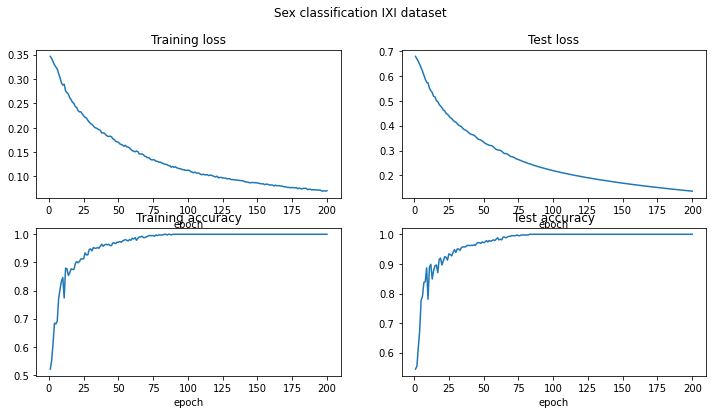

In [14]:
import matplotlib.pyplot as plt

epochs = np.arange(1, len(epoch_loss_values) +1)

plt.figure("train/test", (12, 6))

plt.subplot(2, 2, 1)
plt.title("Training loss")
plt.xlabel("epoch")
plt.plot(epochs, epoch_loss_values)

plt.subplot(2, 2, 2)
plt.title("Test loss")
plt.xlabel("epoch")
plt.plot(epochs, val_loss)

plt.subplot(2, 2, 3)
plt.title("Training accuracy")
y = train_accuracy
plt.xlabel("epoch")
plt.plot(epochs, train_accuracy)

plt.subplot(2, 2, 4)
plt.title("Test accuracy")
plt.xlabel("epoch")
plt.plot(epochs, val_accuracy)
plt.suptitle("Sex classification IXI dataset")
plt.show()